# Hypotheses: 
* [ANOVA] Among surface temperature distribution from 1800 to 1810, from 1900 to 1910 and from 2000 to 2010, at least one of them is significantly different?
* [z/t-test multi-comparison] Among the periods above, which period's difference is statistically significant?

# import library

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import  multipletests

# read & clean  datasets

In [2]:
temp_co_df = pd.read_csv("data/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv")
temp_co_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [3]:
temp_co_df.shape

(577462, 4)

In [4]:
temp_co_df.columns = list(temp_co_df.columns[:1]) + ["ave_temp", "ave_temp_uncer"] + list(temp_co_df.columns[3:].str.lower()) 
temp_co_df.head()

,dt,ave_temp,ave_temp_uncer,country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [5]:
dt_split_df = temp_co_df["dt"].str.split("-", expand=True)
dt_split_df.columns = ["year", "month", "day"]
dt_split_df.head()

,year,month,day
0,1743,11,01
1,1743,12,01
2,1744,01,01
3,1744,02,01
4,1744,03,01


In [6]:
dt_split_df.shape

(577462, 3)

In [7]:
temp_co_df = pd.concat([temp_co_df, dt_split_df], axis=1)
temp_co_df.head()

,dt,ave_temp,ave_temp_uncer,country,year,month,day
0,1743-11-01,4.384,2.294,Åland,1743,11,01
1,1743-12-01,NaN,NaN,Åland,1743,12,01
2,1744-01-01,NaN,NaN,Åland,1744,01,01
3,1744-02-01,NaN,NaN,Åland,1744,02,01
4,1744-03-01,NaN,NaN,Åland,1744,03,01


In [8]:
temp_co_df.shape

(577462, 7)

In [9]:
temp_co_df["dt"] = pd.to_datetime(temp_co_df["dt"])
temp_co_df["year"] = temp_co_df["year"].astype(int)
temp_co_df["month"] = temp_co_df["month"].astype(int)
temp_co_df["day"] = temp_co_df["day"].astype(int)
temp_co_df.dtypes

dt                datetime64[ns]
ave_temp                 float64
ave_temp_uncer           float64
country                   object
year                       int64
month                      int64
day                        int64
dtype: object

# filter usa data & low uncertainty period

In [10]:
temp_us_df = temp_co_df[temp_co_df["country"] == "United States"]
temp_us_df.head()

,dt,ave_temp,ave_temp_uncer,country,year,month,day
554880,1768-09-01,15.420,2.880,United States,1768,9,1
554881,1768-10-01,8.162,3.386,United States,1768,10,1
554882,1768-11-01,1.591,3.783,United States,1768,11,1
554883,1768-12-01,-2.882,4.979,United States,1768,12,1
554884,1769-01-01,-3.952,4.856,United States,1769,1,1


In [11]:
temp_us_df.shape

(2941, 7)

In [12]:
temp_us_year_gr = temp_us_df.groupby(by="year")
temp_us_year_df = temp_us_year_gr.mean().reset_index()
temp_us_year_df.head()

,year,ave_temp,ave_temp_uncer,month,day
0,1768,5.57275,3.757000,10.5,1.0
1,1769,10.44650,3.693375,6.5,1.0
2,1770,NaN,NaN,6.5,1.0
3,1771,NaN,NaN,6.5,1.0
4,1772,NaN,NaN,6.5,1.0


In [13]:
temp_us_year_df.shape

(246, 5)

Text(0.5,1,'average temp in each year')

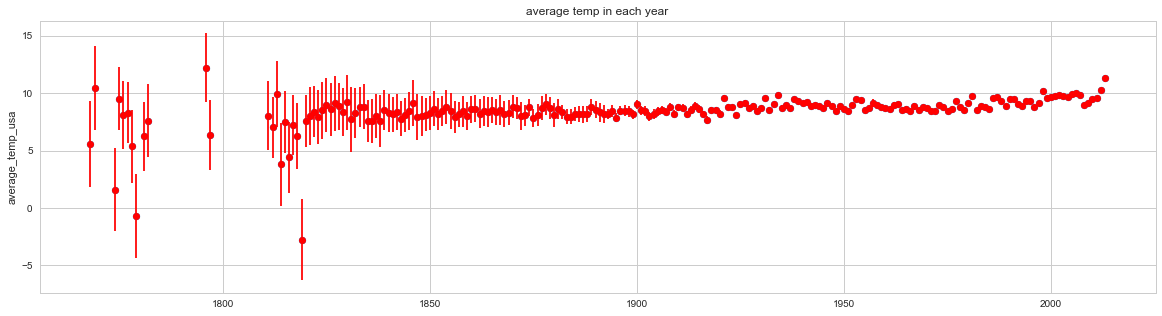

In [14]:
fig, ax = plt.subplots(figsize=(20,5))

ax.scatter("year", "ave_temp", data=temp_us_year_df)
ax.errorbar("year","ave_temp",yerr="ave_temp_uncer", data=temp_us_year_df, fmt='ro',)
ax.set_ylabel("average_temp_usa")
ax.set_title("average temp in each year")

In [15]:
temp_us_1850_df = temp_us_year_df[temp_us_year_df["year"] >= 1850]
temp_us_1850_df.head()

,year,ave_temp,ave_temp_uncer,month,day
82,1850,8.248333,1.492167,6.5,1.0
83,1851,8.657500,1.526000,6.5,1.0
84,1852,8.183083,1.393750,6.5,1.0
85,1853,8.459917,1.291333,6.5,1.0
86,1854,8.821250,1.484083,6.5,1.0


In [16]:
temp_us_1850_df.shape

(164, 5)

# average temperature change since 1900

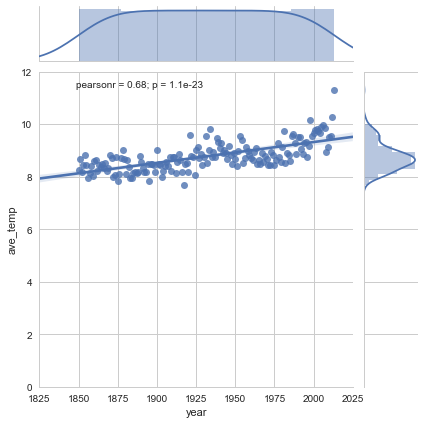

In [17]:
sns.jointplot("year", "ave_temp", data=temp_us_1850_df, kind="reg", xlim=(1825, 2025), ylim=(0,12))

# distribution of average temp in each period

In [18]:
def set_period(year):
    if 2000 <= year:
        return "2000-2013"
    elif year < 1900:
        return "1850-1899"
    elif 1950 <= year:
        return "1950-1999"
    else:
        return "1900-1949"

In [19]:
temp_us_1850_df["period"] = temp_us_1850_df["year"].apply(set_period)
temp_us_1850_df.head()

,year,ave_temp,ave_temp_uncer,month,day,period
82,1850,8.248333,1.492167,6.5,1.0,1850-1899
83,1851,8.657500,1.526000,6.5,1.0,1850-1899
84,1852,8.183083,1.393750,6.5,1.0,1850-1899
85,1853,8.459917,1.291333,6.5,1.0,1850-1899
86,1854,8.821250,1.484083,6.5,1.0,1850-1899


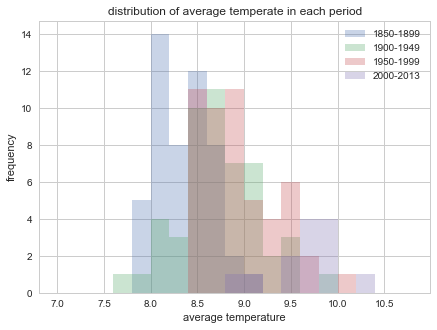

In [20]:
fig, ax = plt.subplots(figsize=(7,5))

temp_bins = np.arange(7, 11, 0.2)

for period in temp_us_1850_df["period"].unique():
    ax.hist(temp_us_1850_df[temp_us_1850_df["period"] == period]["ave_temp"], bins=temp_bins, label=period, alpha=.3)

ax.set_ylabel("frequency")
ax.set_xlabel("average temperature")
ax.set_title("distribution of average temperate in each period")
ax.legend()

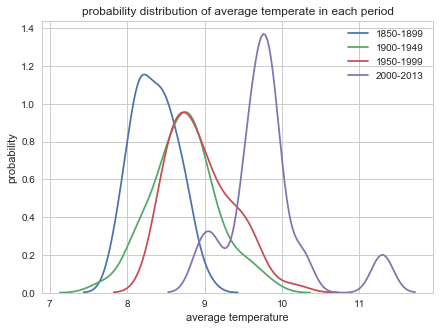

In [21]:
fig, ax = plt.subplots(figsize=(7,5))

temp_bins = np.arange(7, 11, 0.2)

for period in temp_us_1850_df["period"].unique():
    sns.distplot(temp_us_1850_df[temp_us_1850_df["period"] == period]["ave_temp"], bins=temp_bins, label=period, hist=False)

ax.set_ylabel("probability")
ax.set_xlabel("average temperature")
ax.set_title("probability distribution of average temperate in each period")
ax.legend()

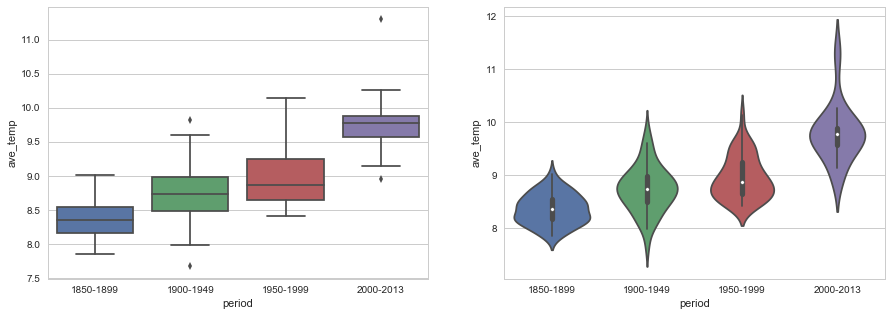

In [22]:
fig,ax = plt.subplots(1,2, figsize = (15,5))

sns.boxplot("period", "ave_temp", data=temp_us_1850_df, ax=ax[0])
sns.violinplot("period", "ave_temp", data=temp_us_1850_df, ax=ax[1])

# ANOVA among 4 periods

In [23]:
temp_period_dict = {} 

for period in temp_us_1850_df["period"].unique():
    temp_period_dict[period] = temp_us_1850_df[temp_us_1850_df["period"] == period]["ave_temp"]

result = stats.f_oneway(temp_period_dict["1850-1899"], temp_period_dict["1900-1949"], temp_period_dict["1950-1999"], temp_period_dict["2000-2013"])
print(result)

F_onewayResult(statistic=53.19357193721584, pvalue=6.622839528245061e-24)


# multiple comparison among 4 periods ~Tukey-Kramer~

In [24]:
result = pairwise_tukeyhsd(temp_us_1850_df["ave_temp"], temp_us_1850_df["period"])
print(result)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff lower  upper  reject
-------------------------------------------------
1850-1899 1900-1949  0.3798  0.1747 0.585   True 
1850-1899 1950-1999  0.5957  0.3905 0.8008  True 
1850-1899 2000-2013  1.4364  1.1262 1.7465  True 
1900-1949 1950-1999  0.2158  0.0107 0.421   True 
1900-1949 2000-2013  1.0565  0.7464 1.3667  True 
1950-1999 2000-2013  0.8407  0.5306 1.1509  True 
-------------------------------------------------


# multiple comaprison among 4 periods ~Bonferroni~
In all combinations, the null hypothesis is rejected. ($ \alpha = \frac{0.05}{4} = 0.0125$)

In [25]:
result = stats.ttest_ind(temp_period_dict["1850-1899"], temp_period_dict["1900-1949"], equal_var=False)
print(result)

Ttest_indResult(statistic=-5.198231080549108, pvalue=1.3802201500994804e-06)


In [26]:
result = stats.ttest_ind(temp_period_dict["1850-1899"], temp_period_dict["1950-1999"], equal_var=False)
print(result)

Ttest_indResult(statistic=-8.524482142862938, pvalue=4.0354758651546464e-13)


In [27]:
result = stats.ttest_ind(temp_period_dict["1850-1899"], temp_period_dict["2000-2013"], equal_var=False)
print(result)

Ttest_indResult(statistic=-9.528470303147438, pvalue=9.291648290555656e-08)


In [28]:
result = stats.ttest_ind(temp_period_dict["1900-1949"], temp_period_dict["1950-1999"], equal_var=False)
print(result)

Ttest_indResult(statistic=-2.575222191743693, pvalue=0.011518359398264353)


In [29]:
result = stats.ttest_ind(temp_period_dict["1900-1949"], temp_period_dict["2000-2013"], equal_var=False)
print(result)

Ttest_indResult(statistic=-6.700182998421717, pvalue=2.8872180651194578e-06)


In [30]:
result = stats.ttest_ind(temp_period_dict["1950-1999"], temp_period_dict["2000-2013"], equal_var=False)
print(result)

Ttest_indResult(statistic=-5.381111659467984, pvalue=4.7401960253630174e-05)


In [31]:
temp_us_year_df.to_csv("data/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry_usaonly_year.csv")

In [32]:
temp_us_df.reset_index().drop("index", axis=1).to_csv("data/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry_usaonly_month.csv")